# Time Series Analysis
**Goal:** Find outliers, trends and periodicity in the MTA turnstile data 

In [1]:
import urllib
import requests
import json
import io
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
import pylab as pl
import datetime
import os

%matplotlib inline

In [2]:
mta_rides = np.load("MTA_Fare.npy")
mta_rides.shape

(600, 23, 194)

In [3]:
#I get this when trying to wget: "/bin/sh: wget: command not found"
#!wget 'https://github.com/fedhere/PUI2017_fb55/raw/master/HW10_fb55/MTA_Fare.npy'

# cmd = "mv MTA_Fare.npy " + os.getenv("PUIDATA")
# os.system(cmd)

# Task one
**Event detection:** Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.

Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.

In [4]:
#taking out nans 
mta_allsum = np.nansum(mta_rides, axis=1)
print (mta_allsum.shape)

#or for all ride types
mta_allsum = np.nansum(mta_allsum, axis=0)

(600, 194)


In [5]:
# create date range
dates = pd.date_range(start='05/21/2010', periods=194, freq='w')

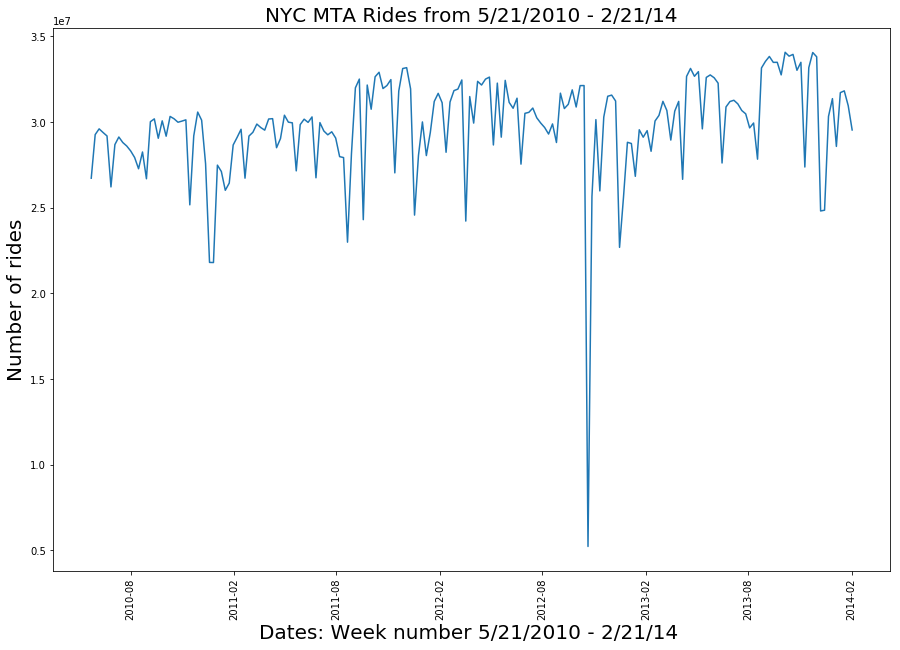

In [6]:
# plotting 
fig = pl.figure(figsize=(15,10))

plt.plot(dates, mta_allsum)
plt.title("NYC MTA Rides from 5/21/2010 - 2/21/14", fontsize=20)
plt.xlabel("Dates: Week number 5/21/2010 - 2/21/14 ", fontsize=20)
plt.ylabel("Number of rides", fontsize=20)
plt.xticks(rotation=90)
plt.show()

**Fig 1:** This timeseries plot shows the number of NYC MTA rides over time. You can see that at around the time of Hurricane Sandy, there was a significant drop in ridership. 

In [7]:
# define 3 sigma threshold
print ("mean rides by day {:.2f}".format(mta_allsum.mean()))
print ("stdev rides by day {:.2f}".format(mta_allsum.std()))
thresholds = [mta_allsum.mean() + 3 * mta_allsum.std(), 
              mta_allsum.mean() - 3 * mta_allsum.std()]
print ("3-sigma thresholds {:.2f} {:.2f}".format(*thresholds))

mean rides by day 29778001.61
stdev rides by day 2984034.35
3-sigma thresholds 38730104.65 20825898.56


In [8]:
len(mta_allsum)

194

In [9]:
# Identify the week that's above the threshold
np.where((mta_allsum < thresholds[1]))

(array([126]),)

In [10]:
# ridership at week 126 (sandy), @ less than 3sigma 
mta_allsum[126]

5215466

In [11]:
# define start time 
start = datetime.datetime.strptime("5/21/2010", "%m/%d/%Y")
# identify time 127 weeks after start time
event_time = start + datetime.timedelta(days=(127*6))
print ("According to this data, the event took place at {}, however, the data is one week off. This event likely tracks to Hurricane Sandy".format(event_time))

According to this data, the event took place at 2012-06-21 00:00:00, however, the data is one week off. This event likely tracks to Hurricane Sandy


# Task two
**Stationarity:** Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the ridership types that have steadily increased in popularity, and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

In [12]:
# create ridetype array
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])   

In [13]:
pd.rolling_mean?

/Users/sebscho/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  import sys


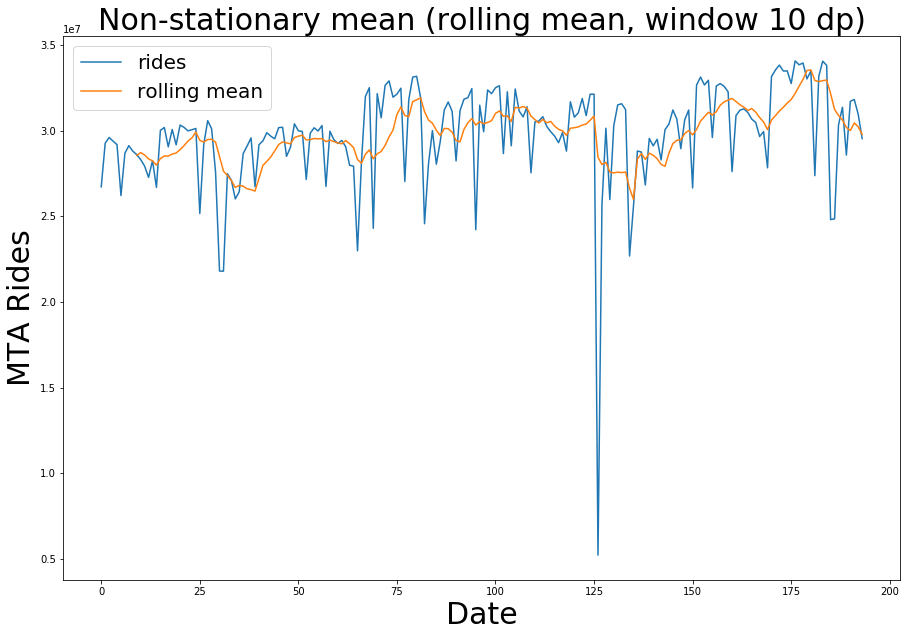

In [14]:
# creating practice rolling means

fig = pl.figure(figsize=(15,10))
ax = fig.add_subplot(111)

#rolling mean, window 10
rides_rmean = pd.rolling_mean(mta_allsum, 10)

ax.plot(np.arange(len(mta_allsum)), mta_allsum, label="rides")
ax.plot(np.arange(len(mta_allsum)), rides_rmean, label="rolling mean")
ax.set_title("Non-stationary mean (rolling mean, window 10 dp)", fontsize=30)
plt.xlabel("Date", fontsize=30)
plt.ylabel("MTA Rides", fontsize=30)
pl.legend(fontsize=20)

**Figure 2:** This plot shows the rolling mean (in orange) of mta rides over time. 

In [15]:
rides = np.nansum(mta_rides, axis=0)
rides.shape

(23, 194)

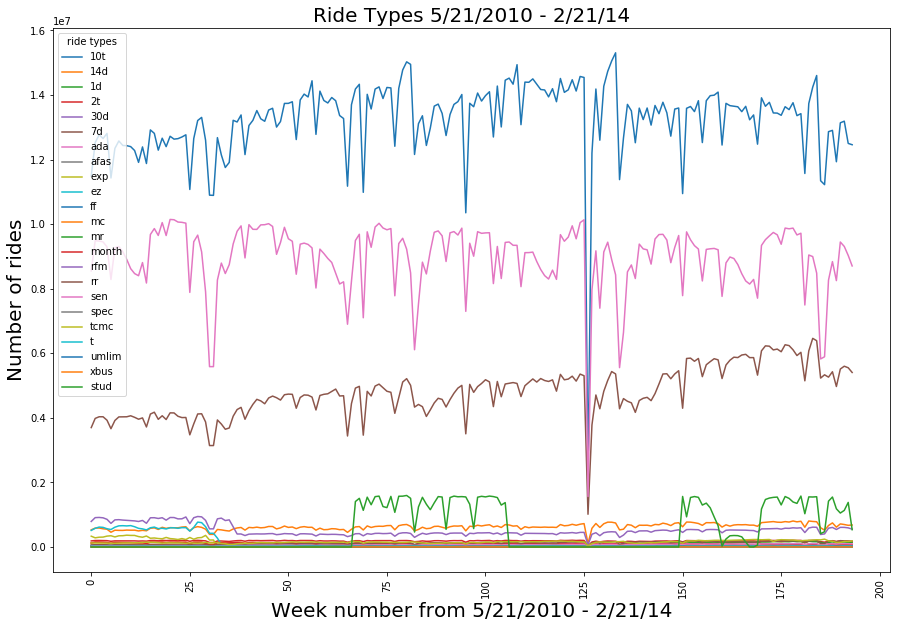

In [16]:
# plot each ridetype by volume over time
fig = plt.figure(figsize=(15,10))

for i, j in zip(rides, ridetype):
    plt.plot(i)
    plt.title("Ride Types 5/21/2010 - 2/21/14", fontsize=20)
    plt.xlabel("Week number from 5/21/2010 - 2/21/14", fontsize=20)
    plt.ylabel("Number of rides", fontsize=20)
    plt.xticks(rotation=90)
    plt.legend(ridetype, title='ride types', fancybox=True)

**Figure 2:** This shows the number of swipes by time for each ridership type. The top type is shown in blue, the 10t pass. The event at week 126 shows Hurricane Sandy, when the subway wasn't running. 

In [17]:
# Making Swipes a dataframe, and pushing it into the right orientation
Swipes = pd.DataFrame(data=rides)
Swipes = Swipes.T
Swipes.head()


,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,11494477,530386,47663,186413,46670,3697305,8551799,9925,333059,511894,...,122996,789972,59671,28083,-138,124555,20922,5990,220,-600
1,12526720,583394,51347,199090,64214,3981669,9486255,11708,282616,577884,...,151809,907929,69070,32194,-139,121574,21531,5981,335,-600
2,12766490,586057,51499,199531,56857,4032893,9476401,12140,301891,615400,...,151401,913987,69437,32481,-137,122044,21296,6353,328,-600
3,12653538,562465,51926,196252,37292,4032616,9449944,11084,305376,606133,...,146957,902412,67962,32267,-137,121914,21493,6453,347,-600
4,12809558,548722,51017,194747,35074,3925310,9293866,10379,335644,563310,...,137752,855437,66241,31797,40,119640,20161,6177,316,-600


In [18]:
# Adding ridetype dictionary to column headers
Swipes.columns = ridetype
Swipes.head()

,10t,14d,1d,2t,30d,7d,ada,afas,exp,ez,...,month,rfm,rr,sen,spec,tcmc,t,umlim,xbus,stud
0,11494477,530386,47663,186413,46670,3697305,8551799,9925,333059,511894,...,122996,789972,59671,28083,-138,124555,20922,5990,220,-600
1,12526720,583394,51347,199090,64214,3981669,9486255,11708,282616,577884,...,151809,907929,69070,32194,-139,121574,21531,5981,335,-600
2,12766490,586057,51499,199531,56857,4032893,9476401,12140,301891,615400,...,151401,913987,69437,32481,-137,122044,21296,6353,328,-600
3,12653538,562465,51926,196252,37292,4032616,9449944,11084,305376,606133,...,146957,902412,67962,32267,-137,121914,21493,6453,347,-600
4,12809558,548722,51017,194747,35074,3925310,9293866,10379,335644,563310,...,137752,855437,66241,31797,40,119640,20161,6177,316,-600


/Users/sebscho/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()
  import sys


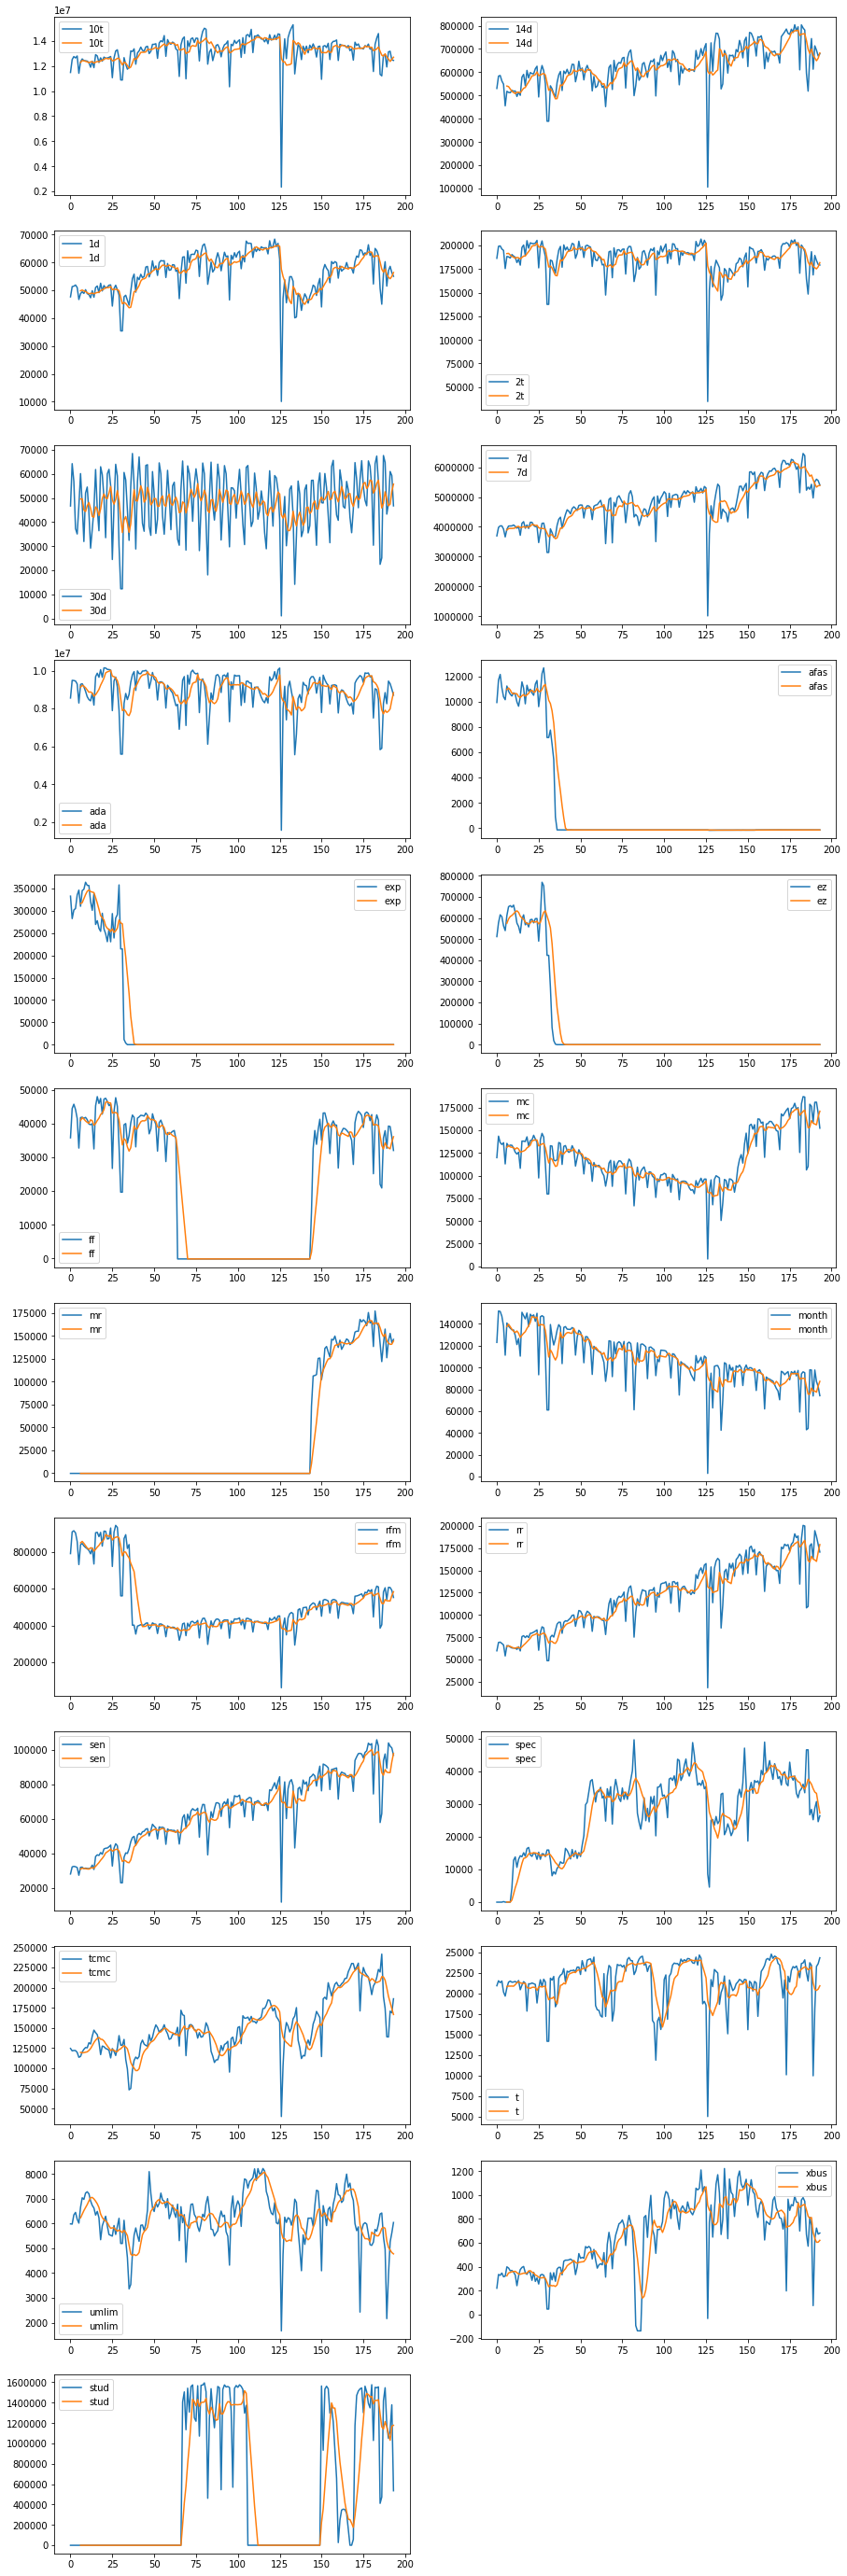

In [19]:
fig = plt.figure(figsize=(15,50))

# plot all the ridetypes 
for i in range(23): 
        ax = fig.add_subplot(12,2,i+1)
        plt.plot(Swipes[ridetype[i]], label=ridetype[i]);
        plt.plot(pd.rolling_mean(Swipes[ridetype[i]], 7));
        ax.legend()

**Fig 4:** These plots show NYC ridership per type of ticket in the NYC from 05/21/2010 to 02/21/2014 by weeks number. The blue shows the data over time, and the orage shows a smoothed rolling mean. We can see visually the trends: "rr" and "sen" are trending upwards. The "month" type is trending down. 

In [20]:
# creating ratios
first_weeks = Swipes.ix[:9,:]
first_weeks = first_weeks.astype(int)

last_weeks = Swipes.ix[-10:,:]
last_weeks = last_weeks.astype(int)

Ratio = pd.DataFrame([first_weeks.mean(), last_weeks.mean()])
Ratio = Ratio.T

/Users/sebscho/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [21]:
Ratio = Ratio.rename(columns={0: 'Beg', 1: 'End'})
Ratio['ratio'] = Ratio['End'] / Ratio['Beg']
Ratio['difference'] = Ratio['End'] - Ratio['Beg']
Ratio.head(23)

,Beg,End,ratio,difference
10t,12347188.9,1.324223e+07,1.072490,895045.450515
14d,533239.0,6.277721e+05,1.177281,94533.113402
1d,49761.7,5.617265e+04,1.128833,6410.954639
2t,190490.3,1.870680e+05,0.982034,-3422.310309
30d,47819.0,4.841916e+04,1.012551,600.159794
7d,3934166.4,4.794516e+06,1.218687,860349.424742
ada,9117434.0,8.958343e+06,0.982551,-159091.252577
afas,10844.1,1.747531e+03,0.161150,-9096.569072
exp,327362.5,4.857032e+04,0.148369,-278792.180412
ez,599081.5,9.926905e+04,0.165702,-499812.448454


In [22]:
# Printing ridetypes that are trending positive
for i in range(22): 
    if (np.min(Swipes[ridetype[i]]) > 0):
        print(ridetype[i])

10t
14d
1d
2t
30d
7d
ada
mc
month
rfm
rr
sen
tcmc
t
umlim


Looking at the ratios and card types, senior citizens have the greatest uptick in ridership, and reduced fare media has the largest reduced fare. With an aging, active population growth in NYC, I'm not surprised to see that this is on the rise. 

# Task three
Several stations show a prominent annual periodicity. Identify the 4 stations (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [23]:
stations = np.nansum(mta_rides, axis=1)
stations.shape

(600, 194)

/Users/sebscho/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/sebscho/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


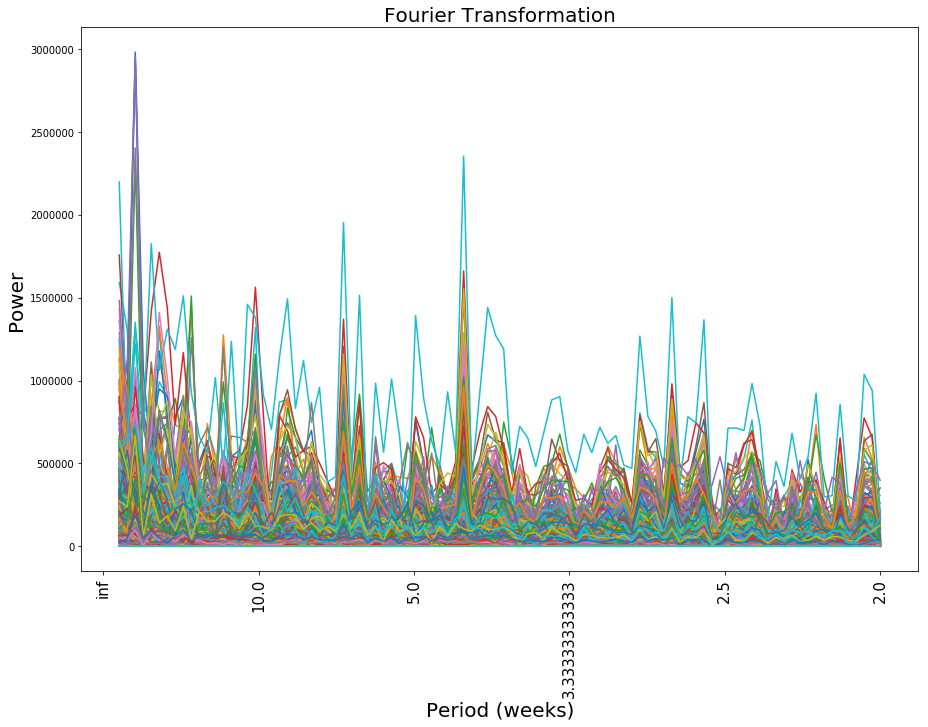

In [24]:
# source: https://github.com/fedhere/UInotebooks/blob/master/timeseries/fourier.ipynb

N = 194
x = np.fft.rfftfreq(N, 1.0)

fig = plt.figure(figsize=(15,10))
plt.title("Fourier Transformation", fontsize=20)
plt.xlabel("Period (weeks)", fontsize=20)
plt.ylabel("Power", fontsize=20)
ax = fig.add_subplot(111)

for i in range(len(stations)):
    f = np.abs(np.fft.rfft(stations[i]))
    plt.plot(x[2:], f[2:], '-')

ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], rotation=90, fontsize=15);

**Fig 5:** The fourier transformation above shows signs of periodicity above the 18000ish power mark. These are worth investigating further.  

/Users/sebscho/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/sebscho/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


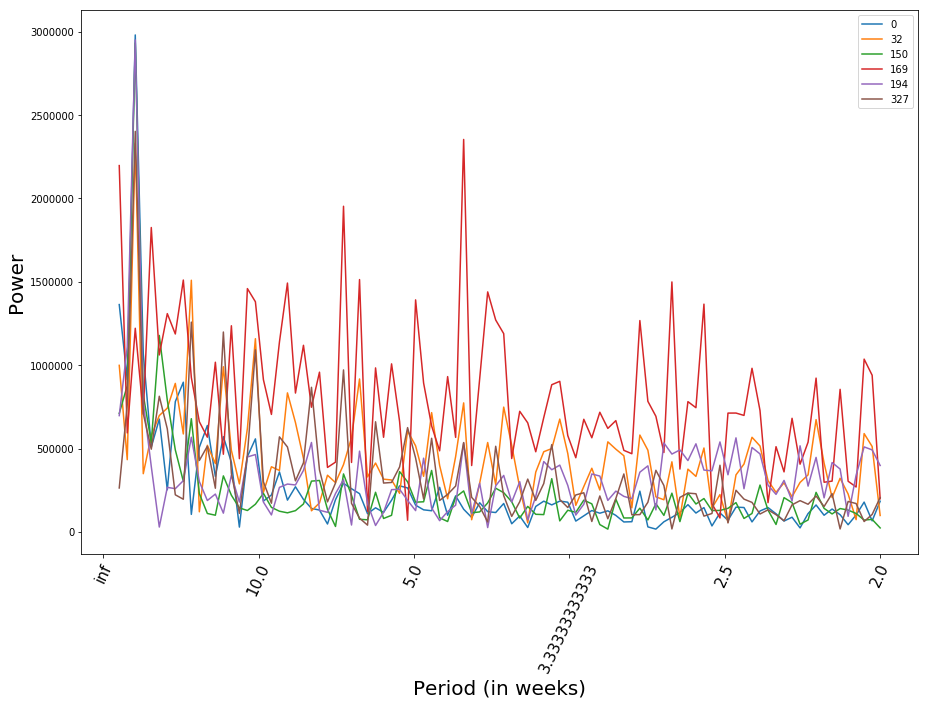

In [25]:
fig = plt.figure(figsize=(15,10))
plt.xlabel("Period (in weeks)", fontsize=20)
plt.ylabel("Power", fontsize=20)
ax = fig.add_subplot(111)
N = 194

x = np.fft.rfftfreq(N, 1.0)

for i in range(len(stations)):
    f = np.abs(np.fft.rfft(stations[i]))
    if f[2:].max() > 2000000:
        plt.plot(x[2:], f[2:], '-', label=i)
        plt.legend()

ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], rotation=65, fontsize=15);

**Fig 6:** This shows fewer stations, but this is still more than we want. Next, we'll increase the threshold until we can identify the four stations with the highest periodicity. '

/Users/sebscho/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/sebscho/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


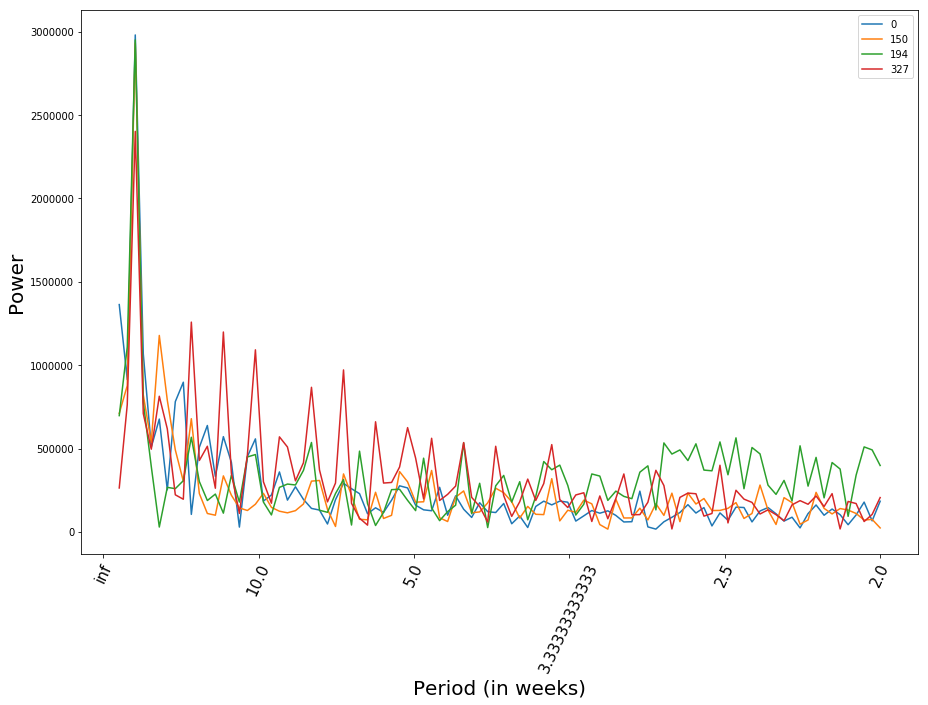

In [26]:
fig = plt.figure(figsize=(15,10))
plt.xlabel("Period (in weeks)", fontsize=20)
plt.ylabel("Power", fontsize=20)
ax = fig.add_subplot(111)
N = 194

x = np.fft.rfftfreq(N, 1.0)

for i in range(len(stations)):
    f = np.abs(np.fft.rfft(stations[i]))
    if f[2:].max() > 2400000:
        plt.plot(x[2:], f[2:], '-', label=i)
        plt.legend()

ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], rotation=65, fontsize=15);

**Fig 7:** This shows the four stations with the highest periodicity. The station numbers are 0, 150, 194, and 327. Next, let's look at the stations for one year only to see if we can identify when in the year they cycle. 

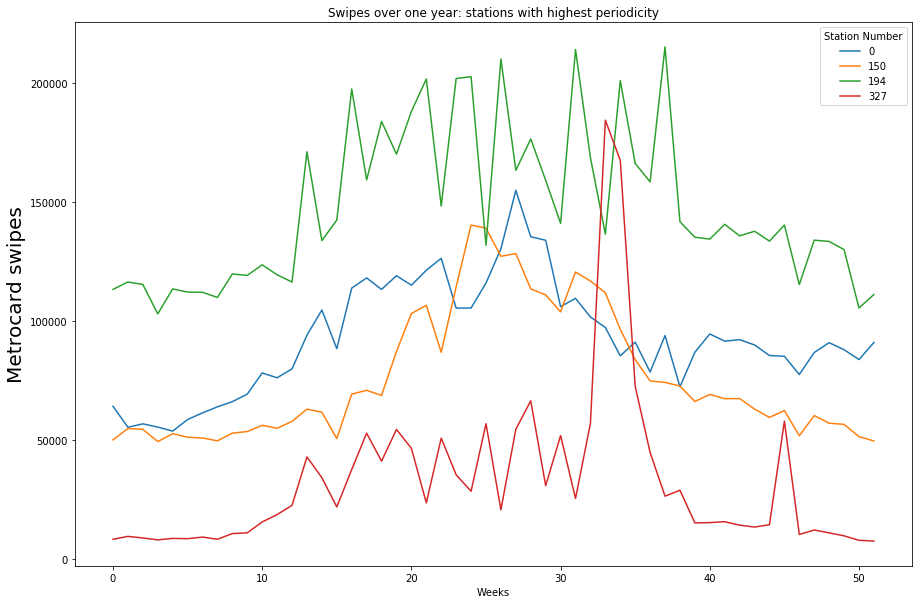

In [27]:
fig = plt.figure(figsize=(15,10))

plt.title("Swipes over one year: stations with highest periodicity")
plt.xlabel("Weeks")
plt.ylabel("Metrocard swipes", fontsize=20)
plt.plot(stations[0,135:187], label='0')
plt.plot(stations[150,135:187], label='150')
plt.plot(stations[194,135:187], label='194')
plt.plot(stations[327,135:187], label='327')
plt.legend(title='Station Number');

**Fig 8:** Here we can see how these four stations perform over time. It appears that the ridership is directly correlated with the seasons. 